In [1]:
def one_hot(vector, max_int=10):
    return np.eye(max_int)[vector]

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
Label for first image: 7
['digits', 'labels']
Shape of input data: (10380, 784)
Shape of input labels: (10380,)
Label for first image: 1
['digits', 'labels']
Shape of test input data: (2580, 784)
Shape of combined images (65380, 784)
Shape of combined labels (65380, 10)


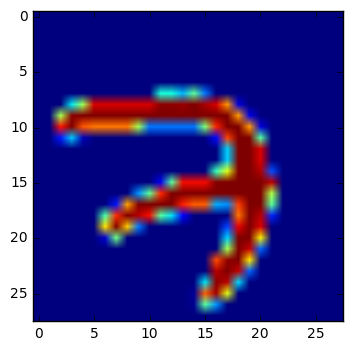

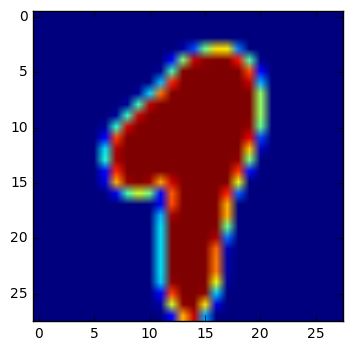

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print(mnist.train.images.shape)

mnist_reshape_first = np.asarray(mnist.train.images)[0,:].reshape(28,28)
plt.imshow(mnist_reshape_first)
print("Label for first image:", np.asarray(mnist.train.labels)[0].argmax())

train_file = np.load('auTrain.npz')
print(train_file.keys())  # ['digits', 'labels']
images = train_file['digits']
labels = train_file['labels']
print('Shape of input data: %s' % (images.shape,))
print('Shape of input labels: %s' % (labels.shape,))
plt.figure()
plt.imshow(images[0,:].reshape(28, 28))
print("Label for first image:", labels[0])

test_file = np.load('auTest.npz')
print(test_file.keys())
images_test = test_file['digits']
labels_test = test_file['labels']
print('Shape of test input data: %s' % (images_test.shape,))

#Append auDigits to mnist data
images_combine = np.concatenate((mnist.train.images, images), axis=0)
print("Shape of combined images", images_combine.shape)

label_mnist_transform = one_hot(labels)
labels_combine = np.concatenate((mnist.train.labels, label_mnist_transform), axis=0)
print("Shape of combined labels", labels_combine.shape)

In [6]:
# Tensorflow

sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')




# Building first layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Building second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# Read
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-4
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100, 0.90, staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy, global_step=global_step)


sess.run(tf.initialize_all_variables())


batch_size = 512
data_points = images_combine.shape[0]
current_data_point_state = data_points
for i in range(2000):
    if current_data_point_state + batch_size > data_points:
        perm = np.random.permutation(data_points)
        images_combine = images_combine[perm,:]
        labels_combine = labels_combine[perm,:]
        current_data_point_state = 0
        print("Learning rate: ", learning_rate.eval())

    
    images_batch = images_combine[current_data_point_state:current_data_point_state + batch_size,:]
    labels_batch = labels_combine[current_data_point_state:current_data_point_state + batch_size,:]
    current_data_point_state = current_data_point_state + batch_size
    
    if i%10 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:images_batch, y_: labels_batch, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    if i%100 == 0:
        test_accuracy = accuracy.eval(feed_dict={x:images_test, y_: one_hot(labels_test), keep_prob: 1.0})
        print("step %d, test accuracy %g"%(i, test_accuracy))
    
    train_step.run(feed_dict={x: images_batch, y_: labels_batch, keep_prob: 0.5})
    
 
  


#print("test accuracy %g"%accuracy.eval(feed_dict={
  #  x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f203970c9e8>>
Traceback (most recent call last):
  File "/home/morten/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 522, in __del__
    self.close()
  File "/home/morten/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1262, in close
    self._default_session.__exit__(None, None, None)
  File "/home/morten/anaconda3/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/home/morten/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3536, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


Learning rate:  0.0001
step 0, training accuracy 0.12
step 0, test accuracy 0.169767
step 10, training accuracy 0.316
step 20, training accuracy 0.542
step 30, training accuracy 0.684
step 40, training accuracy 0.772
step 50, training accuracy 0.792
step 60, training accuracy 0.85
step 70, training accuracy 0.856
step 80, training accuracy 0.854
step 90, training accuracy 0.886
step 100, training accuracy 0.878
step 100, test accuracy 0.803876
step 110, training accuracy 0.888
step 120, training accuracy 0.874
Learning rate:  9e-05
step 130, training accuracy 0.9
step 140, training accuracy 0.892
step 150, training accuracy 0.906
step 160, training accuracy 0.914
step 170, training accuracy 0.922
step 180, training accuracy 0.92
step 190, training accuracy 0.936
step 200, training accuracy 0.934
step 200, test accuracy 0.872093


KeyboardInterrupt: 

(2580, 1)
[ True  True False ...,  True  True False]
[False False  True ..., False False  True]
(2580, 784)
(2580,)
Actual label = 3
Guessed label = 8


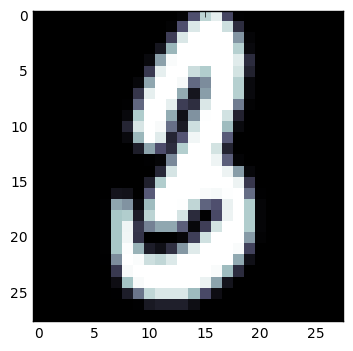

Actual label = 2
Guessed label = 0


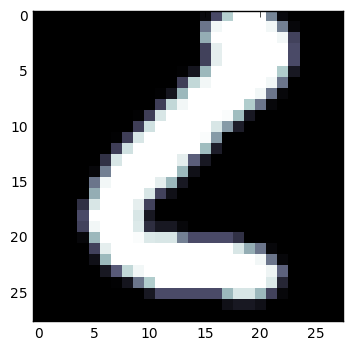

Actual label = 7
Guessed label = 9


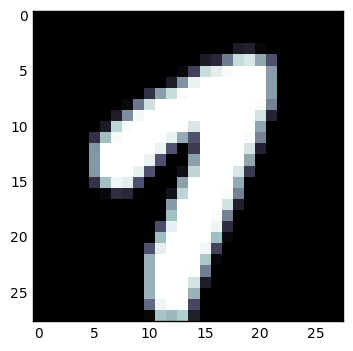

Actual label = 3
Guessed label = 1


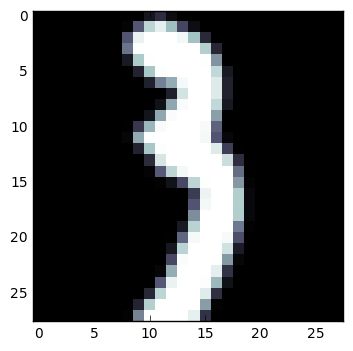

Actual label = 8
Guessed label = 9


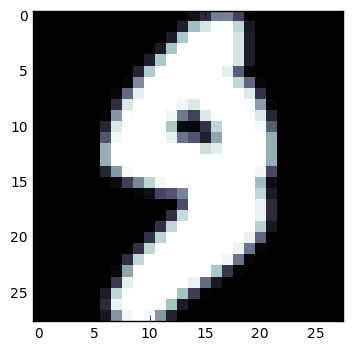

Actual label = 8
Guessed label = 0


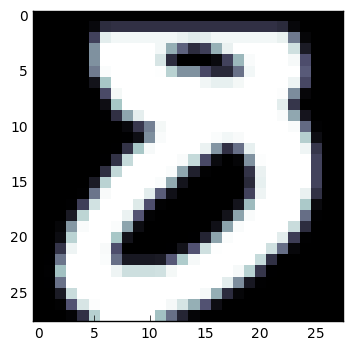

Actual label = 1
Guessed label = 9


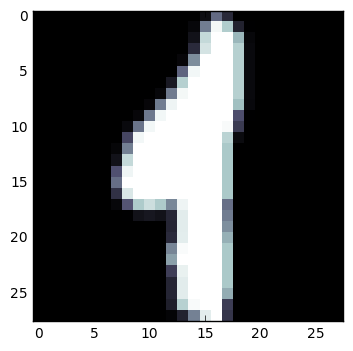

Actual label = 3
Guessed label = 9


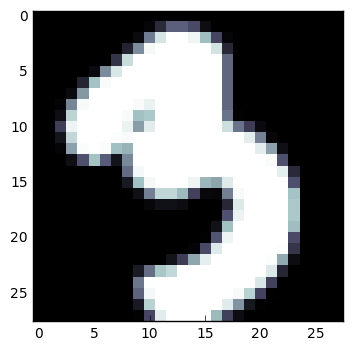

Actual label = 6
Guessed label = 5


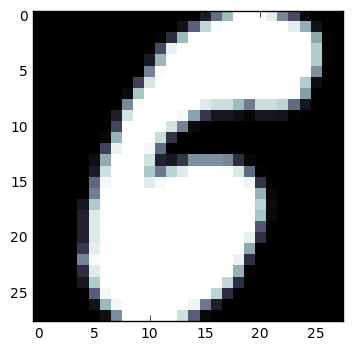

Actual label = 6
Guessed label = 8


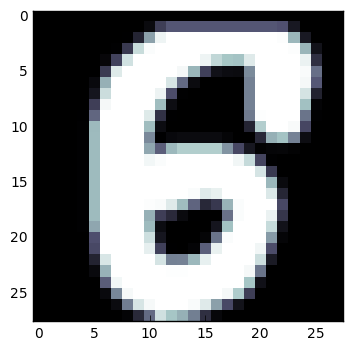

In [44]:
cPred = correct_prediction.eval(feed_dict={x:images_test, y_: one_hot(labels_test), keep_prob:1.0})
print(cPred.reshape(-1,1).shape)
print(cPred)
cPred = np.invert(cPred)
print(cPred)
print(images_test.shape)
gLabels = tf.argmax(y_conv,1).eval(feed_dict={x:images_test, y_: one_hot(labels_test), keep_prob:1.0})
print(gLabels.shape)
for i in range(10):
    image = images_test[cPred,:][i,:]
    label = labels_test[cPred][i]
    glabel = gLabels[cPred][i]
    print("Actual label = " + str(label))
    print("Guessed label = " + str(glabel))
    plt.figure(i)
    plt.imshow(image.reshape((28,-1)), interpolation="nearest", cmap="bone")
    plt.show()